# Complexity demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from google import genai
from google.genai import types

from utils import get_key
from complexity import CQAnalysis

from prompts import PROMPT_COMP, SYSTEM_ROLE_COMP
from config import LLM_CONFIG, SET_MAPPING


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/jacopodeberardinis/anaconda3/envs/bmenv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/jacopodeberardinis/anaconda3/envs/bmenv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/jacopodeberardinis/anaconda3/envs/bmenv/lib/python3.12/site-packages/ipykernel/kernel

Successfully loaded spaCy model 'en_core_web_sm'


In [3]:

MODEL = "gemini-1.5-pro"
MODEL = "gemini-2.5-pro-preview-03-25"
KEY = get_key("gemini")

In [6]:
client = genai.Client(api_key=KEY)

In [3]:
cq_df = pd.read_csv("../data/bme_cq_measures.csv")
cqs = [cq for cq in cq_df["cq"].to_list() if cq is not None and len(cq) > 5]

print(f"Loaded {len(cqs)} CQs from {cq_df.shape[0]} rows")

Loaded 204 CQs from 204 rows


## Complexity measures

### Warm-up: number of characters

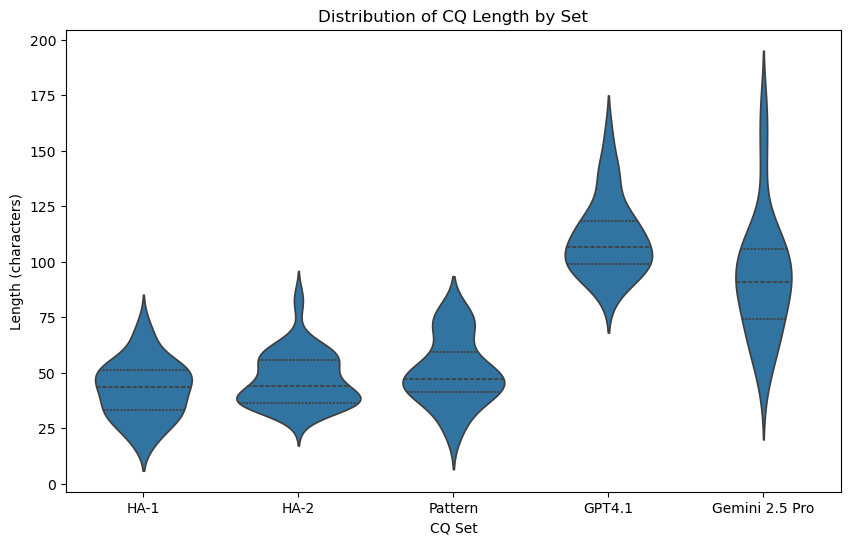

In [5]:
# Now plot the distribution of the number of characters of each CQ per set.
def plot_cq_length_distribution(cq_df):
    """
    Plot the distribution of the number of characters of each CQ per set.
    """
    cq_df["length"] = cq_df["cq"].apply(lambda x: len(x) if x is not None else 0)
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="set", y="length", data=cq_df, inner="quartile")
    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["HA-1", "HA-2", "Pattern", "GPT4.1", "Gemini 2.5 Pro"])
    plt.xlabel("CQ Set")
    plt.ylabel("Length (characters)")
    plt.title("Distribution of CQ Length by Set")
    plt.show()
plot_cq_length_distribution(cq_df)

In [4]:
# add a new column to the dataframe with the CQ length
if "c0_length" not in cq_df.columns:
    cq_df["c0_length"] = cq_df["cq"].apply(lambda x: len(x) if x is not None else 0)
    
test_cq = cqs[76]
print(f"Testing CQ: {test_cq}")

Testing CQ: Which events are associated to a given item?


### C1: Ontology Primitives Analysis

In [11]:
from complexity import calculate_complexity_score

def ontoprimitives_analysis(cq: str):
    """
    Use the complexity_ontoprimitives function to compute the complexity of a CQ.
    """
    response = client.models.generate_content(
        model=MODEL,
        config=types.GenerateContentConfig(
            response_mime_type='application/json',
            response_schema=CQAnalysis,
            system_instruction=SYSTEM_ROLE_COMP,
            temperature=LLM_CONFIG["temperature"],
            top_p=LLM_CONFIG["top_p"],
            frequency_penalty=LLM_CONFIG["frequency_penalty"],
            presence_penalty=LLM_CONFIG["presence_penalty"],
            seed=LLM_CONFIG["seed"],
        ),
        contents=PROMPT_COMP.format(cq=cq),
    )
    # Create a new instance of the CQAnalysis class
    analysis: CQAnalysis = response.parsed
    # Compute the complexity score and the feautures
    complexity, features = calculate_complexity_score(analysis)
    return complexity, features, analysis

In [12]:
# Print the analysis for the first example CQ
print(f"Competency Question: {test_cq}")
complexity, features, analysis = ontoprimitives_analysis(test_cq)
analysis.print_analysis()
print(f"Complexity score: {complexity}")

Competency Question: Which events are associated to a given item?
Concepts:
  - Event
  - Item
Properties:
  - name
Relationships:
  - hasAssociatedEvent
Filters:
  - filter by a specific Item instance
Cardinality Hint: multiple
Aggregation Hint: none
Rationale: The competency question asks to retrieve `Event` entities based on their association with a specific `Item`.
1. **Concepts**: `Event` and `Item` are directly derived from the nouns 'events' and 'item' in the question.
2. **Properties**: The phrase 'a given item' implies that the `Item` must be identifiable, necessitating an identifying property like `name` (or an ID). Similarly, to answer 'Which events', the resulting `Event` entities must be identifiable, also implying a property like `name`. Thus, a generic `name` property is included for identification purposes.
3. **Relationships**: The connection 'events are associated to a given item' is modeled by a relationship `hasAssociatedEvent` from `Item` to `Event`.
4. **Filters**

#### 🔥 C1 on FULL SET

In [17]:
# Perform the analysis for all CQs in the dataframe (cq_df) which returns:
# a complexity score, a list of features, and the full analysis object. The
# analysis object is exported as a dictionary (`to_dict()`) and for convenience
# we also append the CQ in the same dictionary object. Both the complexity
# score and the features update the dataframe as new columns (prefixed by "c1_")

# Create a copy of the DataFrame to avoid modifying the original
cq_opc_df = cq_df.copy()
cq_opc_analysis = []
# Initialize columns for complexity score and features (prefix "c1_")
cq_opc_df["c1_complexity"] = np.nan
cq_opc_df["c1_concepts"] = None
cq_opc_df["c1_properties"] = None
cq_opc_df["c1_relationships"] = None
cq_opc_df["c1_filters"] = None
cq_opc_df["c1_cardinality_hint"] = None
cq_opc_df["c1_aggregation_hint"] = None

for i, cq in tqdm(enumerate(cq_opc_df["cq"]), total=len(cq_opc_df["cq"])):
    try:  # wrap the analysis in a try-except block to handle errors
        complexity, features, analysis = ontoprimitives_analysis(cq)
        cq_opc_df.at[i, "c1_complexity"] = complexity
        for k, v in features.items():
            cq_opc_df.at[i, "c1_" + k] = v
        cq_opc_analysis.append(analysis.to_dict())
    except Exception as e:
        print(f"Error processing CQ {i}: {e}")
    time.sleep(.5)  # Delay to avoid rate limiting


100%|██████████| 198/198 [12:16<00:00,  3.72s/it]


In [18]:
cq_opc_df.to_csv("../data/bme_cq_opc_analysis.csv", index=False)
# also save the analysis as a json file for later inspection
with open("../data/bme_cq_opc_analysis.json", "w") as f:
    json.dump(cq_opc_analysis, f, indent=4)

In [5]:
# read the analysis from the CSV file
cq_opc_df = pd.read_csv("../data/bme_cq_opc_analysis.csv")

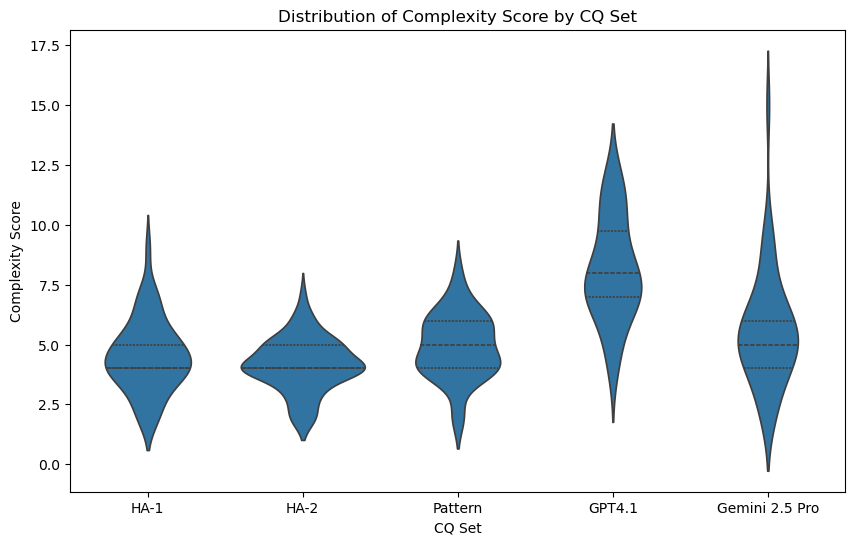

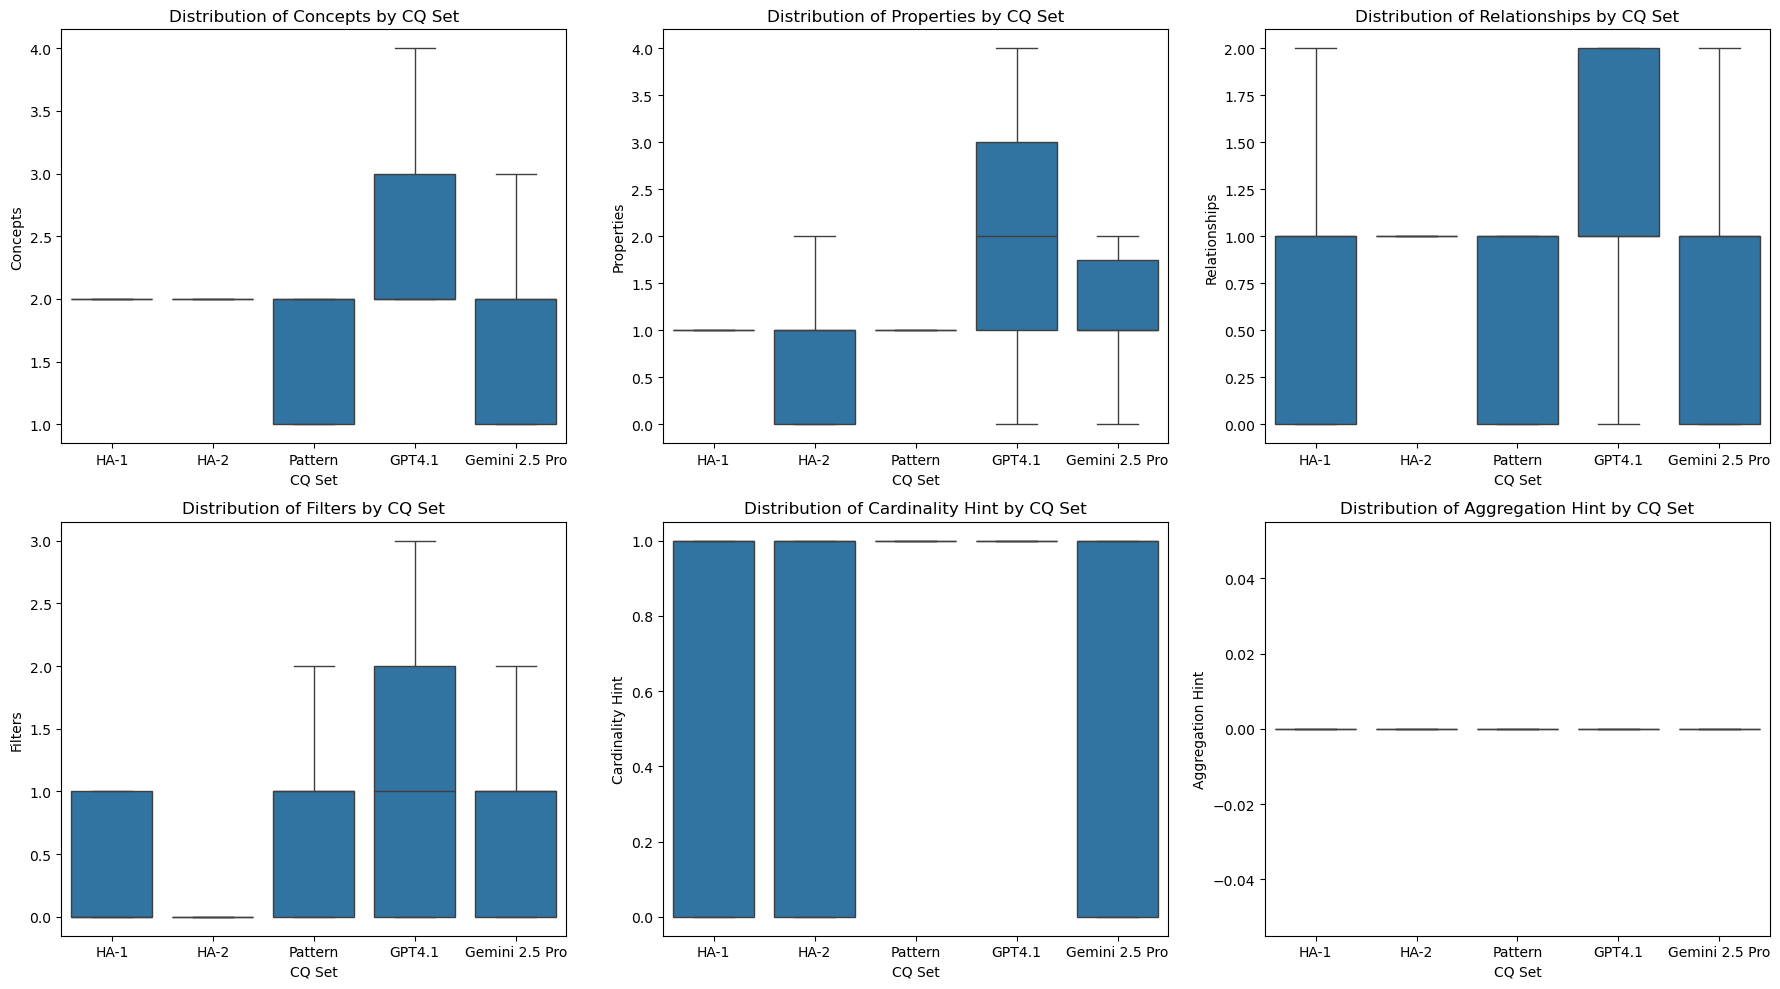

In [6]:
# The cq_opc_df dataframe contains the complexity score and the features for each CQ measure.
# Plot the distribution of the complexity score for each set. The dataframe contains a column
# "set" that indicates the set number for each CQ measure. The set number is an integer from 1 to 5,
# and the set name is the corresponding string from the set_mapping dictionary. The dataframe also
# contains a column "c1_complexity" that indicates the complexity score assigned by the annotators.
def plot_complexity_distribution(cq_opc_df):
    """
    Plot the distribution of the complexity score for each set.
    """
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="set", y="c1_complexity", data=cq_opc_df, inner="quartile")
    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["HA-1", "HA-2", "Pattern", "GPT4.1", "Gemini 2.5 Pro"])
    plt.xlabel("CQ Set")
    plt.ylabel("Complexity Score")
    plt.title("Distribution of Complexity Score by CQ Set")
    plt.show()
    
plot_complexity_distribution(cq_opc_df)

# do the same for the number of concepts, properties, relationships, filters, cardinality hint and aggregation hint
# but use a boxplot instead of a violin plot and subplot the results into a single figure
def plot_complexity_features(cq_opc_df):
    """
    Plot the distribution of the complexity features for each set.
    """
    features = ["c1_concepts", "c1_properties", "c1_relationships", "c1_filters", "c1_cardinality_hint", "c1_aggregation_hint"]
    feature_names = ["Concepts", "Properties", "Relationships", "Filters", "Cardinality Hint", "Aggregation Hint"]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        sns.boxplot(x="set", y=feature, data=cq_opc_df, ax=axes[i], showfliers=False)
        # sns.violinplot(x="set", y=feature, data=cq_opc_df, ax=axes[i], alpha=0.3)
        axes[i].set_xticks([0, 1, 2, 3, 4])
        axes[i].set_xticklabels(["HA-1", "HA-2", "Pattern", "GPT4.1", "Gemini 2.5 Pro"])
        axes[i].set_xlabel("CQ Set")
        axes[i].set_ylabel(feature_names[i])
        axes[i].set_title(f"Distribution of {feature_names[i]} by CQ Set")
    
    plt.tight_layout()
    plt.show()
plot_complexity_features(cq_opc_df)

### C2: Linguistic Complexity

In [7]:
import spacy
from complexity import analyse_linguistic_complexity

SPACY_MODEL_NAME = "en_core_web_sm"
NLP = spacy.load(SPACY_MODEL_NAME)

lc_score, lc_features = analyse_linguistic_complexity(test_cq, NLP)

In [8]:
# Create a copy of the DataFrame to avoid modifying the original
cq_lc_df = cq_opc_df.copy()
# Initialize columns for complexity score and features (prefix "c2_")
cq_lc_df["c2_complexity"] = np.nan
cq_opc_df["c2_num_noun_phrases"] = None
cq_lc_df["c2_num_verbs"] = None
cq_lc_df["c2_num_prepositions"] = None
cq_lc_df["c2_num_conjunctions"] = None
cq_lc_df["c2_num_modifiers"] = None

for i, cq in tqdm(enumerate(cq_lc_df["cq"]), total=len(cq_lc_df["cq"])):
    try:  # wrap the analysis in a try-except block to handle errors
        lc_score, lc_features = analyse_linguistic_complexity(cq, NLP)
        cq_lc_df.at[i, "c2_complexity"] = lc_score
        for k, v in lc_features.items():
            if k != "question_type":
                cq_lc_df.at[i, "c2_" + k] = v
    except Exception as e:
        print(f"Error processing CQ {i}: {e}")


100%|██████████| 198/198 [00:01<00:00, 106.88it/s]


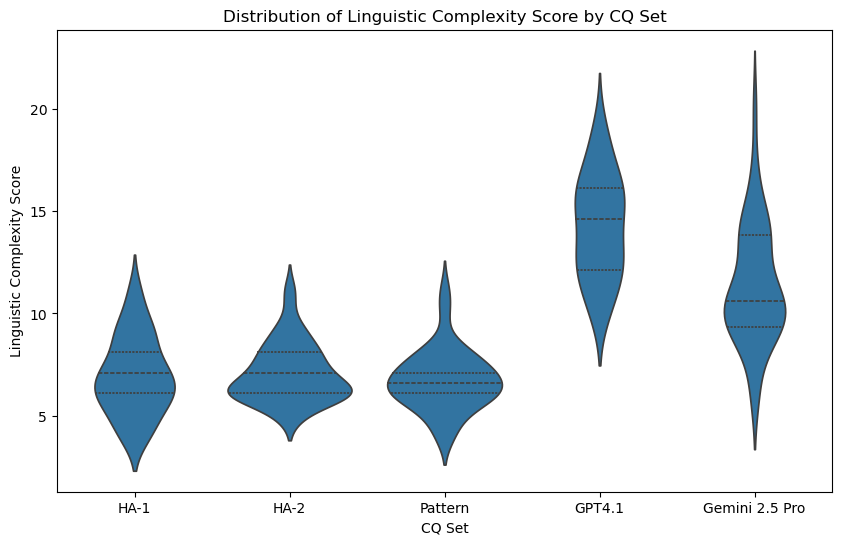

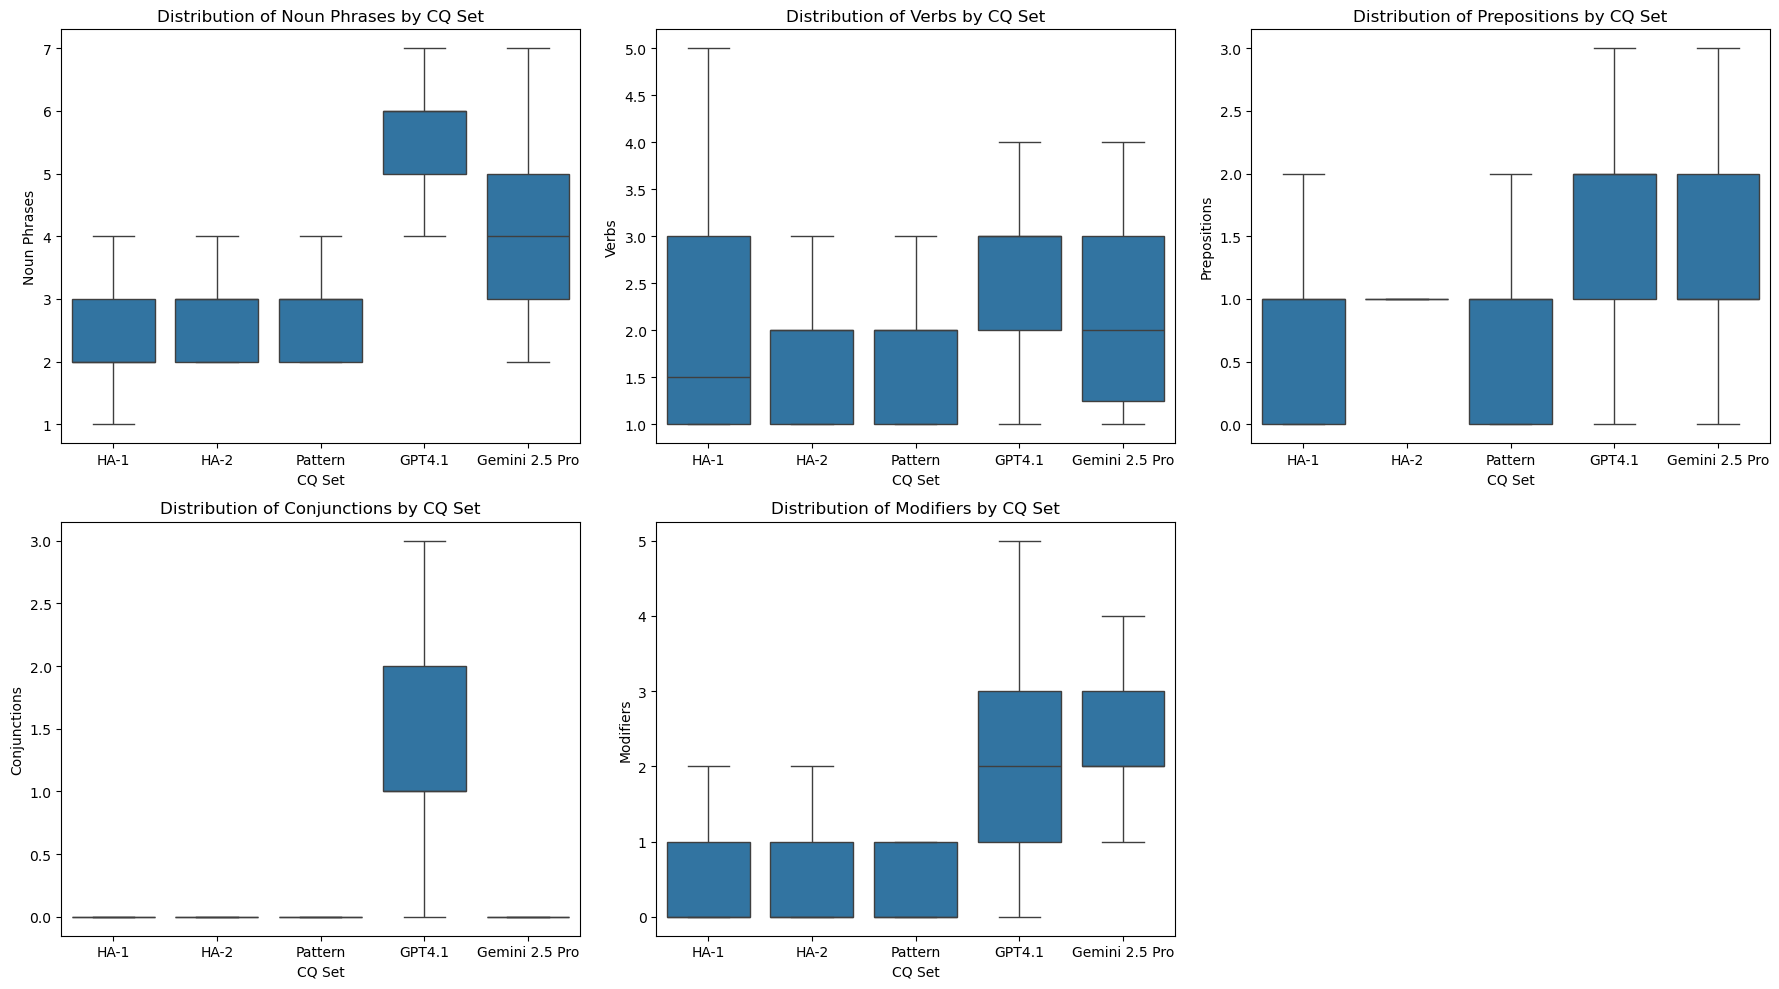

In [9]:
# Plot the distribution of the linguistic complexity score for each set.

plt.figure(figsize=(10, 6))
sns.violinplot(x="set", y="c2_complexity", data=cq_lc_df, inner="quartile")
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["HA-1", "HA-2", "Pattern", "GPT4.1", "Gemini 2.5 Pro"])
plt.xlabel("CQ Set")
plt.ylabel("Linguistic Complexity Score")
plt.title("Distribution of Linguistic Complexity Score by CQ Set")
plt.show()

# and same for the number of noun phrases, verbs, prepositions, conjunctions and modifiers
# but using a boxplot and subplotting the results into a single figure

features = ["c2_num_noun_phrases", "c2_num_verbs", "c2_num_prepositions", "c2_num_conjunctions", "c2_num_modifiers"]
feature_names = ["Noun Phrases", "Verbs", "Prepositions", "Conjunctions", "Modifiers"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x="set", y=feature, data=cq_lc_df, ax=axes[i], showfliers=False)
    # sns.violinplot(x="set", y=feature, data=cq_lc_df, ax=axes[i], alpha=0.3)
    axes[i].set_xticks([0, 1, 2, 3, 4])
    axes[i].set_xticklabels(["HA-1", "HA-2", "Pattern", "GPT4.1", "Gemini 2.5 Pro"])
    axes[i].set_xlabel("CQ Set")
    axes[i].set_ylabel(feature_names[i])
    axes[i].set_title(f"Distribution of {feature_names[i]} by CQ Set")

# swith off the last plot
axes[-1].axis("off")    
plt.tight_layout()
plt.show()

### C3: Syntactic Complexity

In [10]:
from complexity import analyse_syntactic_complexity

analyse_syntactic_complexity(test_cq, NLP)

(15.1,
 {'node_count': 8,
  'tree_depth': 3,
  'relevant_dep_counts': {'nsubjpass': 1, 'prep': 1, 'amod': 1, 'pobj': 1},
  'total_relevant_deps': 4})

In [11]:
# Create a copy of the DataFrame to avoid modifying the original
cq_sc_df = cq_lc_df.copy()
# Initialize columns for complexity score and features (prefix "c2_")
cq_sc_df["c3_complexity"] = np.nan
cq_sc_df["c3_node_count"] = None
cq_sc_df["c3_tree_depth"] = None
cq_sc_df["c3_total_relevant_deps"] = None


for i, cq in tqdm(enumerate(cq_sc_df["cq"]), total=len(cq_sc_df["cq"])):
    try:  # wrap the analysis in a try-except block to handle errors
        sc_score, sc_features = analyse_syntactic_complexity(cq, NLP)
        cq_sc_df.at[i, "c3_complexity"] = sc_score
        for k in ["node_count", "tree_depth", "total_relevant_deps"]:
            cq_sc_df.at[i, "c3_" + k] = sc_features[k]
    except Exception as e:
        print(f"Error processing CQ {i}: {e}")


  0%|          | 0/198 [00:00<?, ?it/s]

100%|██████████| 198/198 [00:01<00:00, 137.55it/s]


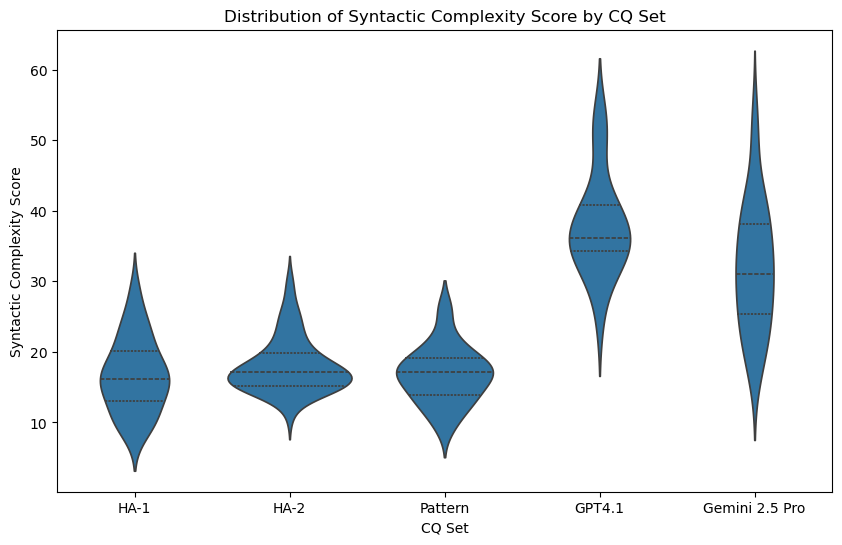

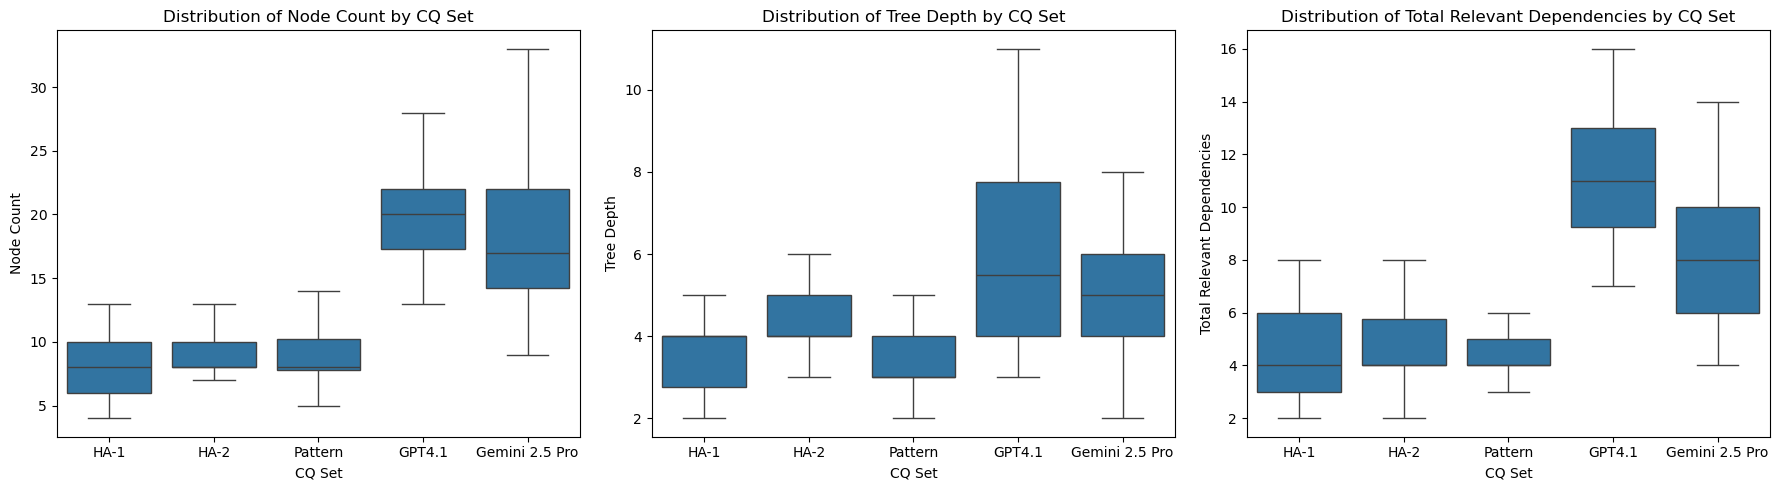

In [12]:
# Plot the distribution of the syntactic complexity score for each set.

plt.figure(figsize=(10, 6))
sns.violinplot(x="set", y="c3_complexity", data=cq_sc_df, inner="quartile")
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["HA-1", "HA-2", "Pattern", "GPT4.1", "Gemini 2.5 Pro"])
plt.xlabel("CQ Set")
plt.ylabel("Syntactic Complexity Score")
plt.title("Distribution of Syntactic Complexity Score by CQ Set")
plt.show()

# And same for the number of nodes, tree depth and total relevant dependencies

features = ["c3_node_count", "c3_tree_depth", "c3_total_relevant_deps"]
feature_names = ["Node Count", "Tree Depth", "Total Relevant Dependencies"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.boxplot(x="set", y=feature, data=cq_sc_df, ax=axes[i], showfliers=False)
    # sns.violinplot(x="set", y=feature, data=cq_sc_df, ax=axes[i], alpha=0.3)
    axes[i].set_xticks([0, 1, 2, 3, 4])
    axes[i].set_xticklabels(["HA-1", "HA-2", "Pattern", "GPT4.1", "Gemini 2.5 Pro"])
    axes[i].set_xlabel("CQ Set")
    axes[i].set_ylabel(feature_names[i])
    axes[i].set_title(f"Distribution of {feature_names[i]} by CQ Set")

plt.tight_layout()
plt.show()

In [19]:
# rename the length column to c0_length
# cq_sc_df.rename(columns={"length": "c0_length"}, inplace=True)
cq_sc_df.columns

Index(['cq', 'set', 'score', 'read_Flesch_kincaid_grade', 'read_Coleman_liau',
       'read_Automated_readability', 'read_Gunning_fog',
       'read_Dale_chall_readability', 'read_Linsear_write', 'read_Clauses',
       'relevance_binary', 'relevance_likert', 'c0_length', 'c1_complexity',
       'c1_concepts', 'c1_properties', 'c1_relationships', 'c1_filters',
       'c1_cardinality_hint', 'c1_aggregation_hint', 'c2_complexity',
       'c2_num_verbs', 'c2_num_prepositions', 'c2_num_conjunctions',
       'c2_num_modifiers', 'c2_num_noun_phrases', 'c3_complexity',
       'c3_node_count', 'c3_tree_depth', 'c3_total_relevant_deps'],
      dtype='object')

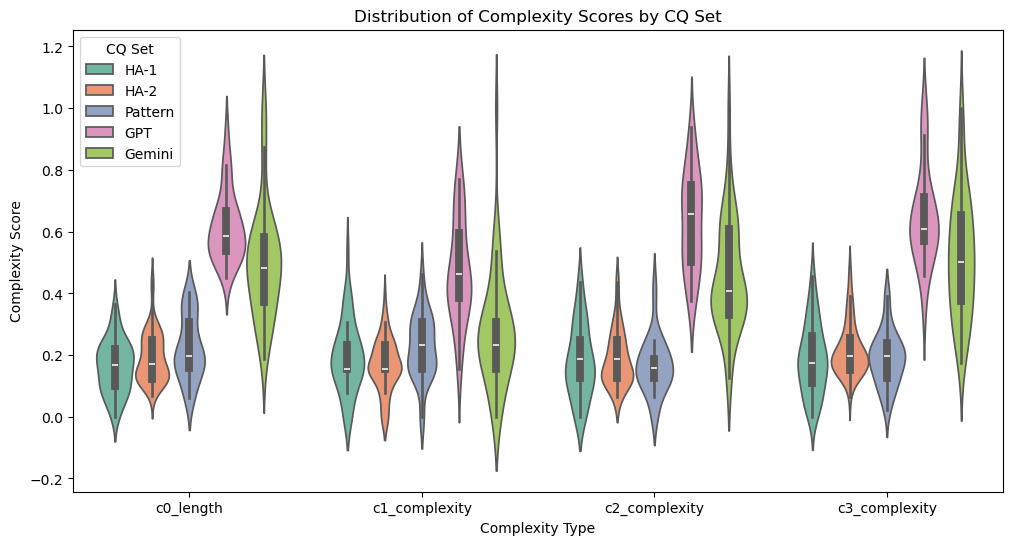

In [38]:
# Now let's plot the distribution of each complexity score (c0, c1, c2, c3) within the same plot using grouped boxplots
# where the x-axis is the complexity type (c0, c1, c2, c3) and the y-axis is the complexity score, and the hue is the set
from config import SET_MAPPING_LIGHT


def plot_complexity_scores(cq_df,
                           complexity_types=["c0_length", "c1_complexity", "c2_complexity", "c3_complexity"],
                           normalise=True):
    """
    Plot the distribution of the complexity scores for each set.
    """
    # Create a new DataFrame with the complexity scores and the set
    cq_scores_df = cq_df[["set"] + complexity_types].copy()
    # Rename the set column via the mapping dictionary
    cq_scores_df["set"] = cq_scores_df["set"].map(SET_MAPPING_LIGHT)
    # Normalise the complexity scores to be between 0 and 1
    if normalise:
        for complexity_type in complexity_types:
            cq_scores_df[complexity_type] = (cq_scores_df[complexity_type] - cq_scores_df[complexity_type].min()) / \
                                             (cq_scores_df[complexity_type].max() - cq_scores_df[complexity_type].min())
    cq_scores_df = cq_scores_df.melt(id_vars=["set"], value_vars=complexity_types,
                                      var_name="complexity_type", value_name="complexity_score")
    
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="complexity_type", y="complexity_score", hue="set", data=cq_scores_df, palette="Set2")#, showfliers=False)
    plt.xlabel("Complexity Type")
    plt.ylabel("Complexity Score")
    plt.title("Distribution of Complexity Scores by CQ Set")
    plt.legend(title="CQ Set")
    # save the figure to PDF
    plt.savefig("../plots/complexity_scores_distribution.pdf", bbox_inches='tight')
    plt.show()
plot_complexity_scores(cq_sc_df, complexity_types=["c0_length", "c1_complexity", "c2_complexity", "c3_complexity"])
# plot_complexity_scores(cq_sc_df, complexity_types=["c1_complexity", "c2_complexity", "c3_complexity"], normalise=False)

In [36]:
complexity_types=["c0_length", "c1_complexity", "c2_complexity", "c3_complexity"]
cq_comp_scores_df = cq_sc_df[["set"] + complexity_types].copy()
cq_comp_scores_df["set"] = cq_comp_scores_df["set"].map(SET_MAPPING)
# Group by set and compute the mean and std
means = cq_comp_scores_df.groupby("set").mean()
stds = cq_comp_scores_df.groupby("set").std()
# Create a dataframe with the means and stds per complexity type (columns) and set (index)
means_stds = pd.DataFrame(index=means.index, columns=complexity_types)
for complexity_type in complexity_types:
    means_stds[complexity_type] = means[complexity_type]
    means_stds[complexity_type + "_std"] = stds[complexity_type]
means_stds = means_stds.reset_index()
means_stds.columns = ["set"] + [f"{c}_mean" for c in complexity_types] + [f"{c}_std" for c in complexity_types]

# order the columns per complexity type
means_stds = means_stds.set_index("set")
means_stds = means_stds.rename_axis("CQ Set").reset_index()
# and make sure the order of rows is the same in SET_MAPPING.keys()
means_stds = means_stds.set_index("CQ Set").reindex(SET_MAPPING.values()).reset_index()

# round the means and stds to 2 decimal places
means_stds = means_stds.round(2)
means_stds

,CQ Set,c0_length_mean,c1_complexity_mean,c2_complexity_mean,c3_complexity_mean,c0_length_std,c1_complexity_std,c2_complexity_std,c3_complexity_std
0,HA-1,42.57,4.52,6.96,16.76,12.94,1.50,1.89,5.27
1,HA-2,46.93,4.17,7.10,18.04,12.01,1.09,1.43,3.87
2,Pattern,51.69,4.94,6.76,16.79,15.53,1.34,1.47,4.03
3,GPT4.1,111.15,8.12,14.25,37.91,17.18,2.14,2.52,7.20
4,Gemini 2.5 Pro,93.50,5.60,11.36,31.96,27.52,2.40,2.87,9.06


In [ ]:

# # discard all columns starting with 'read_' and 'relevance_'
# cq_sc_df = cq_sc_df.loc[:, ~cq_sc_df.columns.str.startswith('read_')]
# cq_sc_df = cq_sc_df.loc[:, ~cq_sc_df.columns.str.startswith('relevance_')]
# # also discard the column named 'score'
# cq_sc_df = cq_sc_df.loc[:, ~cq_sc_df.columns.str.startswith('score')]

# # add a column named 'c0_length' with the length of the CQ as 3rd column
# cq_sc_df.insert(2, "c0_length", cq_sc_df["cq"].apply(lambda x: len(x) if x is not None else 0))

# # save this dataframe to a csv file
# cq_sc_df.to_csv("../data/bme_cq_complexity.csv", index=False)

## Correlation analysis

In [ ]:
# Using cq_sc_df (which contains all the complexity scores and features) and cq_df (which contains the
# inter-annotator agreement scores), we can compute the correlation between the complexity scores and
# features and the inter-annotator agreement scores. The correlation is computed using the Pearson
# correlation coefficient, which measures the linear relationship between two variables. The correlation
# coefficient is a value between -1 and 1, where -1 indicates a perfect negative correlation, 0 indicates
# no correlation, and 1 indicates a perfect positive correlation. The correlation is computed for each
# complexity score and feature with respect to the inter-annotator agreement scores. The correlation
# coefficients are stored in a dictionary, where the keys are the names of the complexity scores and
# features, and the values are the correlation coefficients with respect to the inter-annotator agreement
# scores. The correlation coefficients are printed to the console.

def compute_correlation(cq_df, cq_opc_df):
    """
    Compute the correlation between the complexity scores and features and the inter-annotator agreement scores.
    """
    correlation = {}
    for feature in cq_opc_df.columns:
        if feature.startswith("c1_") or feature.startswith("c2_") or feature.startswith("c3_"):
            # Compute the correlation with respect to the inter-annotator agreement scores
            correlation[feature] = cq_df["score"].corr(cq_opc_df[feature])
    return correlation

correlation = compute_correlation(cq_df, cq_sc_df)
print("Correlation between complexity scores and CQ scores:")
for feature, corr in correlation.items():
    print(f"{feature}: {corr:.2f}")

Correlation between complexity scores and CQ scores:
c1_complexity: -0.18
c1_concepts: 0.00
c1_properties: -0.16
c1_relationships: -0.01
c1_filters: -0.20
c1_cardinality_hint: -0.19
c1_aggregation_hint: 0.07
c2_num_noun_phrases: -0.01
c2_complexity: -0.02
c2_num_verbs: -0.14
c2_num_prepositions: -0.01
c2_num_conjunctions: -0.01
c2_num_modifiers: 0.09
c3_complexity: 0.02
c3_node_count: 0.00
c3_tree_depth: 0.10
c3_total_relevant_deps: -0.01


In [ ]:

def correlation_by_set(cq_sc_df):
    """
    Plot the correlation between the complexity scores and features and the inter-annotator agreement scores.
    """
    set_correlation = {}
    for set_num, set_name in set_mapping.items():
        set_df = cq_sc_df[cq_sc_df["set"] == set_num]
        set_cq_sc_df = cq_sc_df[cq_sc_df["set"] == set_num]
        correlation = {}
        for feature in cq_sc_df.columns:
            if feature.startswith("c1_") or feature.startswith("c2_") or feature.startswith("c3_"):
                # Compute the correlation with respect to the inter-annotator agreement scores
                correlation[feature] = set_df["score"].corr(cq_sc_df[feature])
        set_correlation[set_name] = correlation
    return set_correlation

set_correlation = correlation_by_set(cq_sc_df)
print("Correlation between complexity scores and CQ scores by set:")
for set_name, correlation in set_correlation.items():
    print(f"{set_name}:")
    for feature, corr in correlation.items():
        print(f"  {feature}: {corr:.2f}")

# Plot the correlation coefficients as a bar plot for each set
def plot_correlation_barplot(set_correlation):
    """
    Plot the correlation coefficients as a bar plot for each set.
    """
    set_names = list(set_correlation.keys())
    features = list(set_correlation[set_names[0]].keys())
    
    # Create a DataFrame for the correlation coefficients
    correlation_df = pd.DataFrame(index=set_names, columns=features)
    for set_name, correlation in set_correlation.items():
        for feature, corr in correlation.items():
            correlation_df.at[set_name, feature] = corr
    
    # Convert the DataFrame to numeric
    correlation_df = correlation_df.apply(pd.to_numeric)
    
    # Plot the bar plot
    plt.figure(figsize=(12, 6))
    correlation_df.plot(kind='bar', figsize=(12, 6))
    plt.title("Correlation between Complexity Scores and Inter-Annotator Agreement Scores by Set")
    plt.xlabel("CQ Set")
    plt.ylabel("Correlation Coefficient")
    plt.xticks(rotation=45)
    plt.legend(title="Complexity Score/Feature")
    plt.tight_layout()
    plt.show()
    
plot_correlation_barplot(set_correlation)

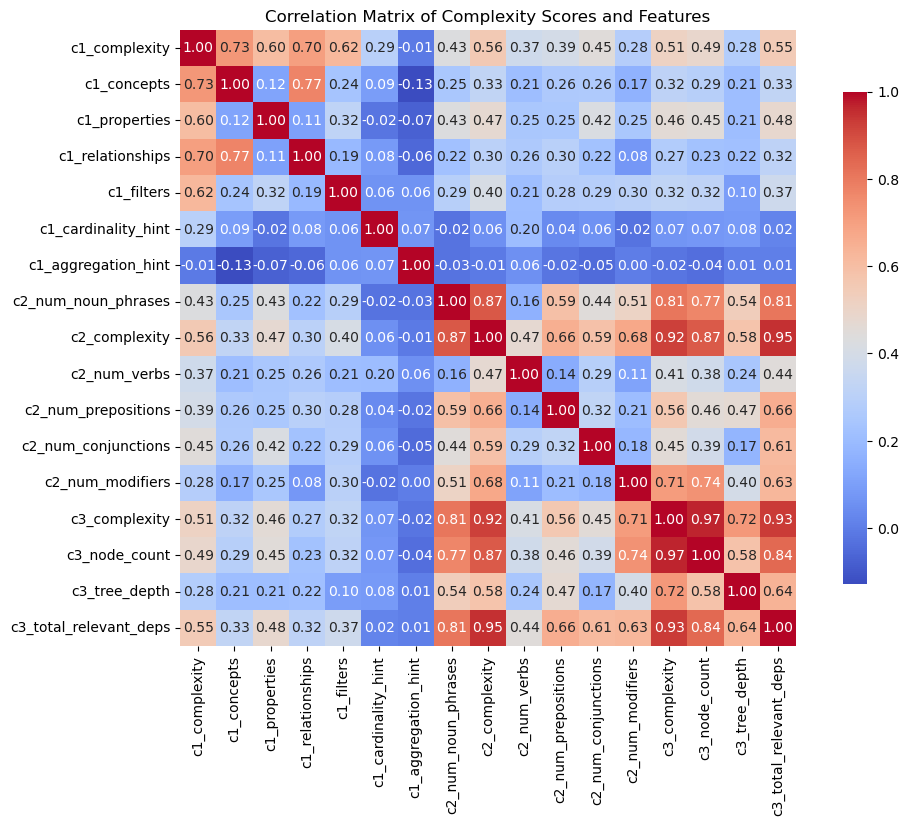

In [ ]:
# Let's focus on c1_complexity, c2_complexity and c3_complexity
# and see if there is a correlation among themselves

# select the columns starting with prefixes "c1_", "c2_" and "c3_"
complexity_columns = [col for col in cq_sc_df.columns if col.startswith(("c1_", "c2_", "c3_"))]
complexity_df = cq_sc_df[complexity_columns].copy()
correlation_matrix = complexity_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Complexity Scores and Features")
plt.show()

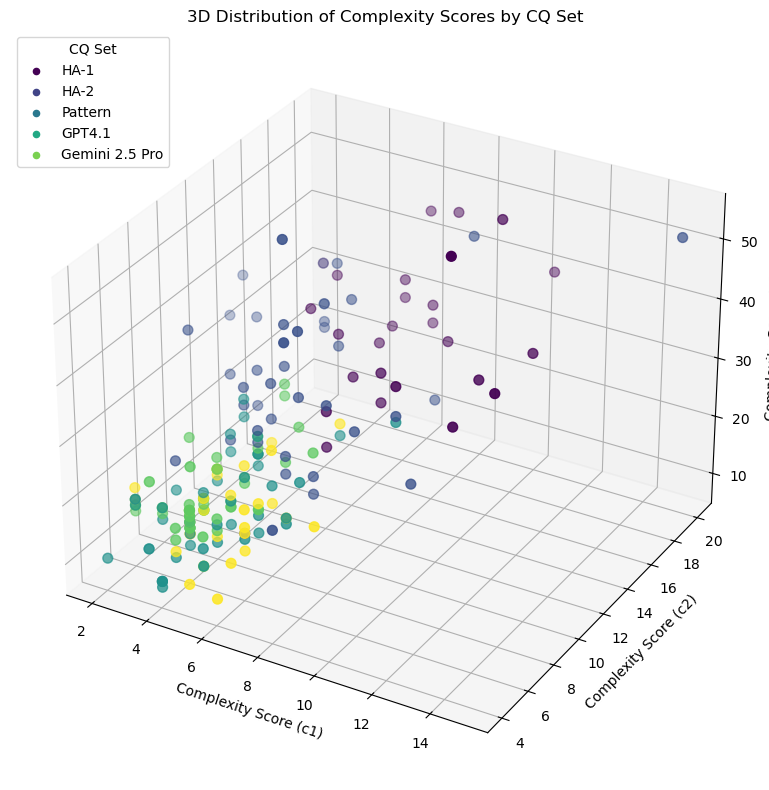

In [ ]:
complexity_scores_df = cq_sc_df[["cq", "set", "c1_complexity", "c2_complexity", "c3_complexity"]].copy()
complexity_scores_df["set"] = complexity_scores_df["set"].map(SET_MAPPING)

# Plot the distribution of the complexity scores as 3D distribution for each set
def plot_3d_distribution(complexity_scores_df):
    """
    Plot the distribution of the complexity scores as 3D distribution for each set.
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a scatter plot
    ax.scatter(complexity_scores_df["c1_complexity"], complexity_scores_df["c2_complexity"], complexity_scores_df["c3_complexity"], c=complexity_scores_df["set"].astype('category').cat.codes, cmap='viridis', s=50)
    # Set labels
    ax.set_xlabel("Complexity Score (c1)")
    ax.set_ylabel("Complexity Score (c2)")
    ax.set_zlabel("Complexity Score (c3)")
    # Set title
    ax.set_title("3D Distribution of Complexity Scores by CQ Set")
    # Set legend
    set_labels = SET_MAPPING.values()
    set_colors = [plt.cm.viridis(i / len(set_labels)) for i in range(len(set_labels))]
    for i, label in enumerate(set_labels):
        ax.scatter([], [], [], color=set_colors[i], label=label)
    ax.legend(title="CQ Set", loc="upper left")
    # Show the plot
    plt.tight_layout()
    plt.show()
    
plot_3d_distribution(complexity_scores_df)
# Plot the distribution of the complexity scores as 3D distribution for each set

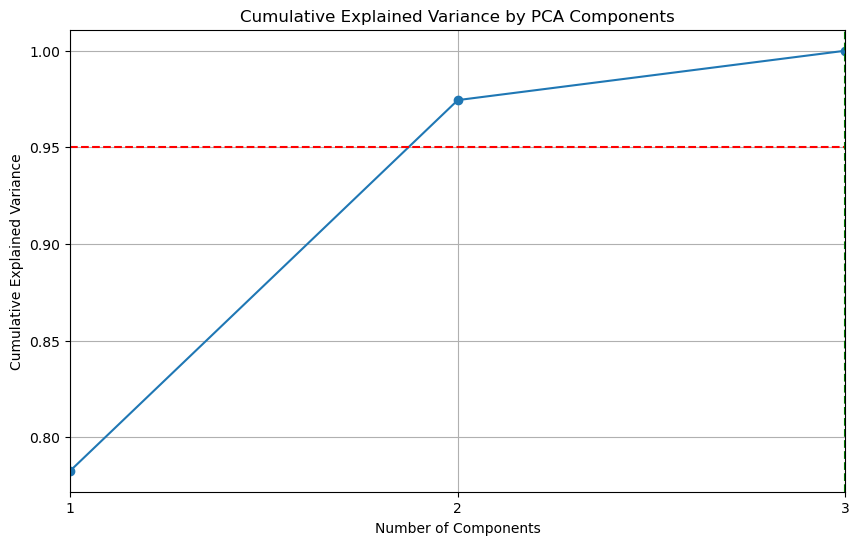

In [ ]:
# Do PCA on the complexity scores (c1_complexity, c2_complexity, c3_complexity)
# and check how many components are needed to explain 95% of the variance

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
complexity_scores_scaled = scaler.fit_transform(complexity_scores_df[["c1_complexity", "c2_complexity", "c3_complexity"]])
# Perform PCA
pca = PCA()
pca.fit(complexity_scores_scaled)
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=2, color='g', linestyle='--')
plt.xticks(range(0, len(cumulative_variance)), range(1, len(cumulative_variance) + 1))
plt.xlim(0, len(cumulative_variance) - 1)
plt.grid()
plt.show()


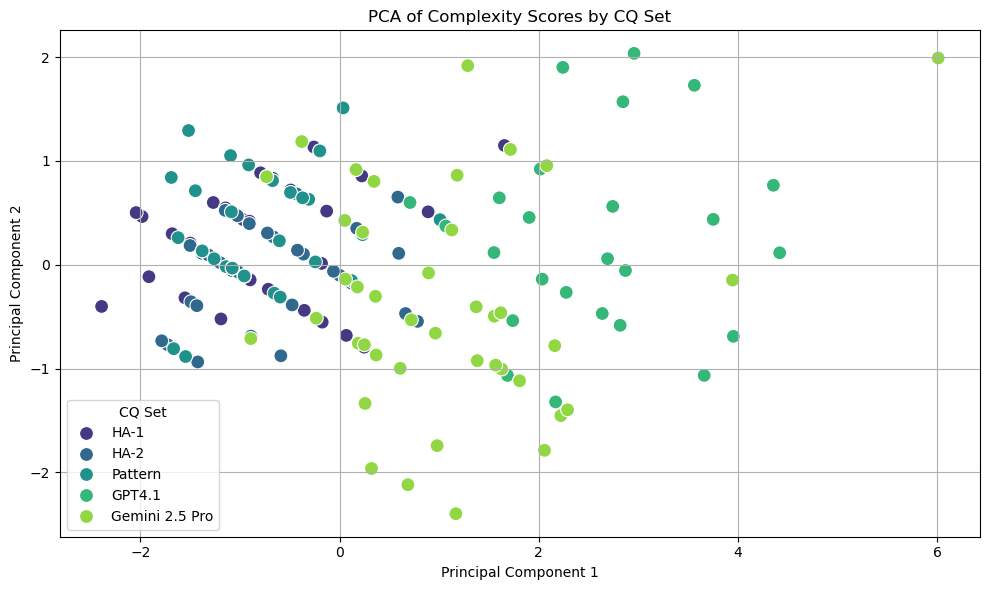

In [50]:
# Use the first two components to plot the complexity scores for each set
pca = PCA(n_components=2)
complexity_scores_pca = pca.fit_transform(complexity_scores_scaled)
# Create a DataFrame with the PCA components and the set labels
pca_df = pd.DataFrame(complexity_scores_pca, columns=["PC1", "PC2"])
pca_df["set"] = complexity_scores_df["set"].values
# Plot the PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PC1", y="PC2", hue="set", data=pca_df, palette="viridis", s=100)
plt.title("PCA of Complexity Scores by CQ Set")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="CQ Set")
plt.grid()
plt.tight_layout()
plt.show()

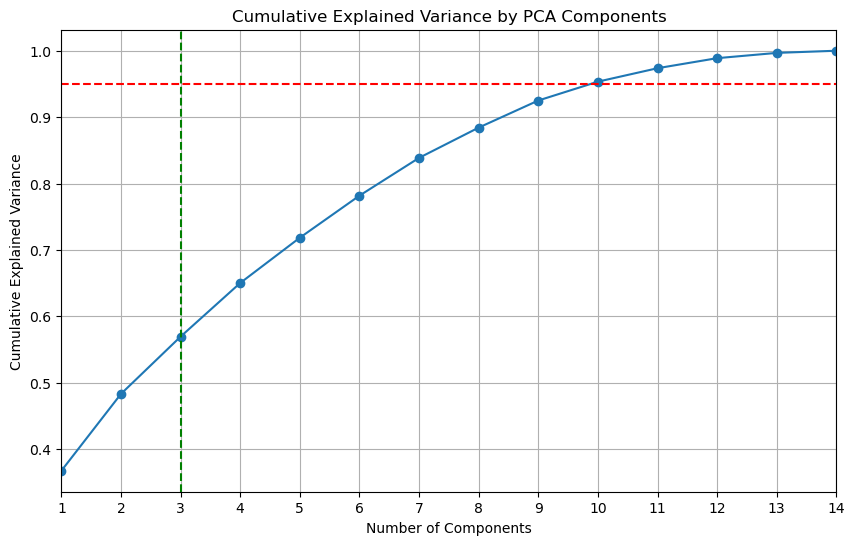

In [ ]:
# Now perform the same PCA study but using all the complexity features
# select the columns starting with prefixes "c1_", "c2_" and "c3_" but exclude the complexity scores
complexity_features = [col for col in cq_sc_df.columns if col.startswith(("c1_", "c2_", "c3_")) and not col.endswith("complexity")]
complexity_features_df = cq_sc_df[complexity_features].copy()
# Standardize the data
scaler = StandardScaler()
complexity_features_scaled = scaler.fit_transform(complexity_features_df)
# Perform PCA
pca = PCA()
pca.fit(complexity_features_scaled)
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.95, color='r', linestyle='--')
# plt.axvline(x=2, color='g', linestyle='--')
plt.xticks(range(0, len(cumulative_variance)), range(1, len(cumulative_variance) + 1))
plt.xlim(0, len(cumulative_variance) - 1)
plt.grid()
plt.show()